In [45]:
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from scipy.stats import beta
from enum import IntEnum
import math
import random

# Set Up

- Storing filename with all the data.

In [46]:
datafilename: str = 'processed.cleveland.data' 

- Encoding feature names since they are not in the file (storing dataset). 
- Assigning names to each of the columns of the data; each number corresponds to the index of the column it is tracking. 
- `num` is the column being predicted. 

In [47]:
class Features(IntEnum):
    age      = 0                              
    sex      = 1
    cp       = 2
    trestbps = 3
    chol     = 4
    fbs      = 5
    restecg  = 6
    thalach  = 7
    exang    = 8
    oldpeak  = 9
    slope    = 10
    ca       = 11
    thal     = 12
    num      = 14

feature_names: list[str] = [feature.name for feature in Features]

- Storing size of the data file 
- Storing number of features

In [48]:
num_samples: int = 303
num_features: int = 13

* Opening and reading data file in `csv` format
* After processing:
  * `data` stores the features
  * `target` stores class labels 

In [49]:
try:
    data = []
    target = []
    with open(datafilename) as infile:
        indata = csv.reader(infile)
        for d in indata:
            ok: bool = True
            # Do not use the record if it has missing values
            for k in range(0, num_features):  
                if d[k] == "?":
                    ok = False
                    break
            if ok:
                data.append([float(x) for x in d[:-1]])
                target.append(int(d[-1]))
    
    data = np.array(data)
    target = np.array(target)
except IOError as iox:
    print('There was an I/O error trying to open the data file:', iox)
    sys.exit(1)
except Exception as x:
    print('There was an error:', x)
    sys.exit(1)

* Checking dataset (number of samples)

In [50]:
num_samples: int = len(data)
print("Number of samples:", num_samples)

Number of samples: 297


* Adjust the size of data and target so that they only hold the values loaded from the CSV file

In [51]:
data = data[:num_samples]
target = target[:num_samples]


* Splitting data into training set and test set

In [52]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=0)


# Learning

## Decision Tree Classifier

**Question 3**

* Classifying using decision tree classifier

In [53]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [54]:
print("Decision tree score:", clf.score(X_test, y_test))

Decision tree score: 0.4666666666666667


## Naive Bayes Classifier

Naive Bayes is a probabilistic classifier that applies Bayes' theorem with a "naive" independence assumption between features. 
It works by:

Mathematically, for a set of features x and class y, Naive Bayes tries to find:

$$p(y_i|x_i, D)$$

Where D is the training data. Using Bayes' theorem, this becomes:

$$p(y_i|x_i, D) = \frac{p(x_i|y_i, D)p(y_i|D)}{p(x_i|D)}$$

The "naive" assumption is that features are conditionally independent given the class. This means:

$$p(x_i|y_i, D) = \prod_j p(a_j|y_i)$$

Where $a_j$ are the individual feature values. This gives us the Naive Bayes classification rule:

$$v_{NB} = \arg\max_{v_i \in V} p(v_i) \prod_j p(a_j|v_i)$$

Why it's used:
1. Simple but effective classifier
2. Works well with small training sets due to the independence assumption
3. Resistant to overfitting because of its simple model
4. Can handle both discrete and continuous features
5. Fast to train and predict since it just requires counting frequencies for discrete features

The code you've shown implements this by:
1. Computing prior probabilities $p(y_i)$ by counting class frequencies
2. Computing conditional probabilities $p(a_j|y_i)$ for each feature value given each class
3. Using these to make predictions according to the Naive Bayes formula

Despite its simplistic assumptions, Naive Bayes often performs surprisingly well in practice, especially for text classification and similar tasks where we have many features.

### Custom Naive Bayes Classifier

**Question 4**

* Building a custom a custom Naive Bayes classifier 
* Focusing on features: `sex`, `cp`, `fbs`, `restecg`, `slope` and `ca`
* The prior probability of each of the outcome values is between 0 and 4 [0 to 4]

#### Prior Probabilities $p(yi)$

In [55]:
y_count: list[float] = [0.0, 0.0, 0.0, 0.0, 0.0]
for i in range(len(y_train)):
    if y_train[i] == 0:
        y_count[0] += 1
    if y_train[i] == 1:
        y_count[1] += 1
    if y_train[i] == 2:
        y_count[2] += 1
    if y_train[i] == 3:
        y_count[3] += 1
    if y_train[i] == 4:
        y_count[4] += 1

# Count how many entries we have:
total = 0
for i in range(len(y_count)):
    total += y_count[i]

# Compute the prior value of each entry
priors: list[int] = [0, 0, 0, 0, 0]
for i in range(len(y_count)):
    priors[i] = y_count[i]/total


#### Conditional Probabilities $p(aj|yi)$ 

* Compute the probability of each value of cp given each value of num:
* `cp` has possible values 1, 2, 3, 4.
* Count the number of entries with each value of `cp`, given a value of num
* `cp` is feature number 2 in the data

In [56]:
cp_num: list[list[float]] = [[0.0, 0.0, 0.0, 0.0],
							[0.0, 0.0, 0.0, 0.0],
							[0.0, 0.0, 0.0, 0.0],
							[0.0, 0.0, 0.0, 0.0],
							[0.0, 0.0, 0.0, 0.0]]


for i in range(len(X_train)):  
    if y_train[i] == 0:        # num = 0
        if X_train[i][2] == 1:
            cp_num[0][0] += 1
        if X_train[i][2] == 2:
            cp_num[0][1] += 1
        if X_train[i][2] == 3:
            cp_num[0][2] += 1
        if X_train[i][2] == 4:
            cp_num[0][3] += 1
 
    if y_train[i] == 1:        # num = 1
        if X_train[i][2] == 1:
            cp_num[1][0] += 1
        if X_train[i][2] == 2:
            cp_num[1][1] += 1
        if X_train[i][2] == 3:
            cp_num[1][2] += 1
        if X_train[i][2] == 4:
            cp_num[1][3] += 1
 
    if y_train[i] == 2:        # num = 2
        if X_train[i][2] == 1:
            cp_num[2][0] += 1
        if X_train[i][2] == 2:
            cp_num[2][1] += 1
        if X_train[i][2] == 3:
            cp_num[2][2] += 1
        if X_train[i][2] == 4:
            cp_num[2][3] += 1
 
    if y_train[i] == 3:        # num = 3
        if X_train[i][2] == 1:
            cp_num[3][0] += 1
        if X_train[i][2] == 2:
            cp_num[3][1] += 1
        if X_train[i][2] == 3:
            cp_num[3][2] += 1
        if X_train[i][2] == 4:
            cp_num[3][3] += 1
 
    if y_train[i] == 4:        # num = 4
        if X_train[i][2] == 1:
            cp_num[4][0] += 1
        if X_train[i][2] == 2:
            cp_num[4][1] += 1
        if X_train[i][2] == 3:
            cp_num[4][2] += 1
        if X_train[i][2] == 4:
            cp_num[4][3] += 1

* Normalising probabilities

In [57]:
for i in range(len(y_count)):
    for j in range(len(cp_num[1])):
        cp_num[i][j] = cp_num[i][j] / y_count[i]

#### Conditional Probabilities $p(aj|yi)$

* Compute the probability of each value of `fbs` given each value of num:
* `fbs` has possible values 1 and 0
* Count the number of entries with each value of `fbs`, given a value of num
* `fbs` is feature number 5 in the data

In [58]:
fbs_num: list[list[float]] = 	[[0.0, 0.0],
								[0.0, 0.0],
								[0.0, 0.0],
								[0.0, 0.0],
								[0.0, 0.0]]
          
for i in range(len(X_train)):  
    if y_train[i] == 0:        # num = 0
        if X_train[i][5] == 0:
            fbs_num[0][0] += 1
        if X_train[i][5] == 1:
            fbs_num[0][1] += 1

    if y_train[i] == 1:        # num = 1
        if X_train[i][5] == 0:
            fbs_num[1][0] += 1
        if X_train[i][5] == 1:
            fbs_num[1][1] += 1

    if y_train[i] == 2:        # num = 2
        if X_train[i][5] == 0:
            fbs_num[2][0] += 1
        if X_train[i][5] == 1:
            fbs_num[2][1] += 1
            
    if y_train[i] == 3:        # num = 3
        if X_train[i][5] == 0:
            fbs_num[3][0] += 1
        if X_train[i][5] == 1:
            fbs_num[3][1] += 1

    if y_train[i] == 4:        # num = 4
        if X_train[i][5] == 0:
            fbs_num[4][0] += 1
        if X_train[i][5] == 1:
            fbs_num[4][1] += 1

* Normalise probabilities

In [59]:
for i in range(len(y_count)):
    for j in range(len(fbs_num[0])):
        fbs_num[i][j] = fbs_num[i][j] / y_count[i]

* Making predictions with the custom Naive Bayes classifier

In [60]:
y_pred: int = 0
score: float = 0.0

for i in range(len(y_test)):
    # Moved prob_num from outside loop so that probabilities are refreshed for each test instance.
    prob_num: list[int] = [1, 1, 1, 1, 1]
    # For each possible value of num, compute p(cp|num)p(fbs|num)p(num) 
    for j in range(len(y_count)): 
        prob_num[j] = prob_num[j] * cp_num[j][(int(X_test[i][2]) - 1)]
        prob_num[j] = prob_num[j] * fbs_num[j][int(X_test[i][5])]
        prob_num[j] = prob_num[j] * priors[j]
    # The element with the maximum value is the prediction
    y_pred: int = prob_num.index(max(prob_num))

    # Is this the right value?
    if y_pred == y_test[i]:
        score += 1
        
print("My Naive Bayes scores: ", score/len(y_test))

My Naive Bayes scores:  0.45


### Built-In Naive Bayes Classifier

**Question 5**

In [61]:
nb = MultinomialNB()
nb = nb.fit(X_train, y_train)

In [62]:
print("Naive Bayes score:", nb.score(X_test, y_test))

Naive Bayes score: 0.48333333333333334


## Comparison

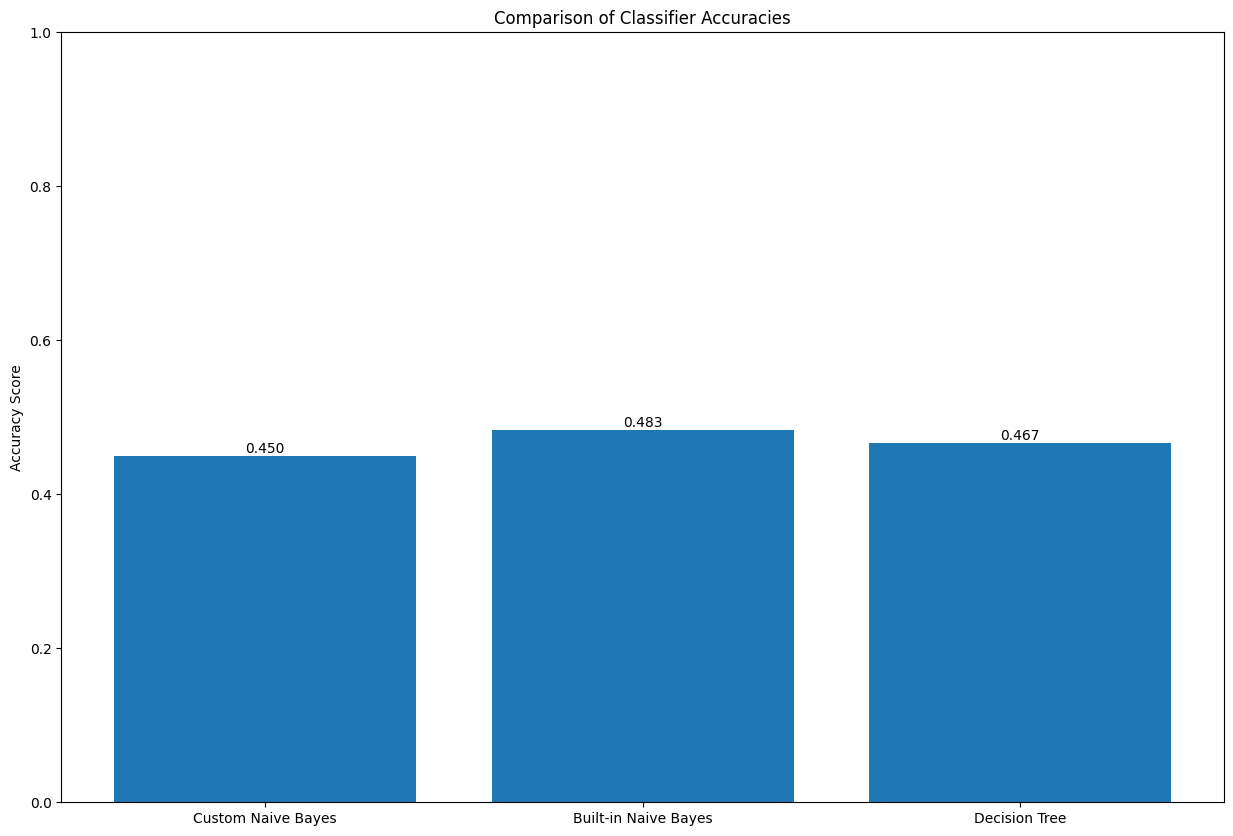

In [63]:
scores = {
	'Custom Naive Bayes': score/len(y_test),  # from previous calculation
	'Built-in Naive Bayes': nb.score(X_test, y_test),  # from sklearn
	'Decision Tree': clf.score(X_test, y_test)  # from sklearn
}

plt.figure(figsize=(15, 10))
plt.ylim(0.4, 0.6)
plt.bar(scores.keys(), scores.values())
plt.title('Comparison of Classifier Accuracies')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1)  # Set y-axis from 0 to 1 since these are accuracy scores

for i, (classifier, score) in enumerate(scores.items()):
	plt.text(i, score, f'{score:.3f}', ha='center', va='bottom')

plt.show()